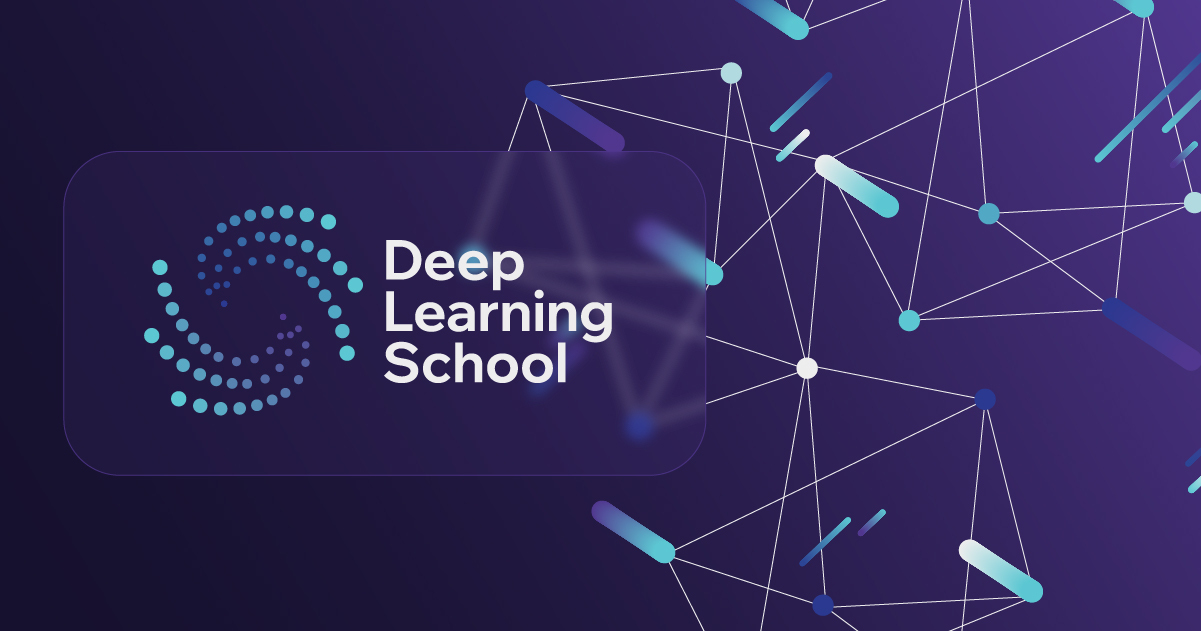

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import distance_box_iou_loss
from torchvision.models.detection.anchor_utils import AnchorGenerator
import torch.optim as optim
from functools import partial

import timm
import matplotlib.pyplot as plt
import io
import gc

import numpy as np
import pandas as pd
import albumentations as A

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.ops import nms, box_iou, sigmoid_focal_loss
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision

In [2]:
# Устройство для вычислений (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [3]:
# Определяем константы для цвета и названий классов, из семинара

class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

Создаем датасет для предобработки данных

In [4]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        # Вычитаем единицу чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Тут можно написать любые аугментации

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Добавляй сюда свои аугментации при необходимости!
        A.Normalize(mean=mean, std=std),
        # HorizontalFlip меняет и ббоксы!
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(),
    ],
    # Раскомментируй, если аугментации изменяют ббоксы.
    # Не забудь указать верный формат для ббоксов.
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.Resize(640, 640),
        ToTensorV2(),
    ]
)

Не забываем инициализировать наш датасет

In [6]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [7]:
# Класс Backbone с resnet50

class Backbone(nn.Module):
    def __init__(self, model_name="resnet50", out_indices=(1, 2, 3, 4), unfreeze_last=0):
        """
        Инициализация бэкбона с возможностью разморозки последних блоков.

        Args:
            model_name (str): Название модели из библиотеки timm.
            out_indices (tuple): Индексы слоев, выходы которых будут использоваться.
            unfreeze_last (int): Количество последних блоков для разморозки.
        """
        super().__init__()
        # Создание модели с предобученными весами и выводом промежуточных признаков
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            features_only=True,
            out_indices=out_indices
        )

        # Заморозка всех параметров модели
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Размораживание последних 'unfreeze_last' блоков
        if unfreeze_last > 0:
            # Получение информации о модулях
            modules = [self.backbone.feature_info[i]['module'] for i in out_indices]
            # Удаление дубликатов и сохранение порядка
            unique_modules = list(dict.fromkeys(modules))
            # Размораживание последних 'unfreeze_last' модулей
            for module_name in unique_modules[-unfreeze_last:]:
                module = dict(self.backbone.named_modules()).get(module_name, None)
                if module is not None:
                    for param in module.parameters():
                        param.requires_grad = True

    def forward(self, x):
        """
        Прямой проход через бэкбон.

        Args:
            x (Tensor): Входной тензор изображения.

        Returns:
            list[Tensor]: Список признаков с указанных уровней.
        """
        return self.backbone(x)



# Рекомендации по выбору Backbone:

# Цель использования	      Рекомендуемые бэкбоны
# Максимальная точность	  ConvNeXt, Swin Transformer
# Баланс скорость/точность  CSPDarkNet53, ResNet50
# Ограниченные ресурсы	  MobileNetV3, EfficientNet-Lite

In [9]:
# Проверка выходов Backbone

# features_only=True: Этот параметр позволяет получить выходы промежуточных слоев модели, что полезно для задач, таких как детекция объектов или сегментация.​
# out_indices: Параметр out_indices определяет, какие уровни признаков будут возвращены. По умолчанию, для resnet50 это (0, 1, 2, 3, 4), соответствующие различным стадиям модели.​
# feature_info: После создания модели с features_only=True, вы можете использовать атрибут feature_info для получения информации о каждом уровне признаков:

# Создание модели ResNet-50 с предобученными весами и выводом промежуточных признаков
model = Backbone(model_name="resnet50").to(device)
model.eval()

# Создание фиктивного входного тензора с размером 640x640
test_image_input = torch.randn(1, 3, 640, 640, device=device)

# Получение выходов модели без вычисления градиентов
with torch.no_grad():
    outputs = model(test_image_input)

# Вывод информации о выходах
print("Количество уровней признаков:", len(outputs))
for idx, feat in enumerate(outputs):
    print(f"Уровень {idx}: размерность = {feat.shape}")


Количество уровней признаков: 4
Уровень 0: размерность = torch.Size([1, 256, 160, 160])
Уровень 1: размерность = torch.Size([1, 512, 80, 80])
Уровень 2: размерность = torch.Size([1, 1024, 40, 40])
Уровень 3: размерность = torch.Size([1, 2048, 20, 20])


### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [10]:
# Класс Feature Pyramid Network Neck (FPN) Neck для использования с Backbone ResNet-50.

class FPNNeck(nn.Module):
    def __init__(self, in_channels_list=[256, 512, 1024, 2048], out_channels=256):
        """
        Feature Pyramid Network (FPN) для ResNet-50.

        Args:
            in_channels_list (list): Количество каналов на выходе каждого уровня признаков из ResNet-50.
            out_channels (int): Желаемое количество каналов на выходе FPN для каждого уровня.
        """
        super().__init__()
        # Латеральные 1x1 свёртки для выравнивания каналов
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            for in_channels in in_channels_list
        ])
        # 3x3 свёртки после слияния
        self.fpn_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])

    def forward(self, features):
        """
        Прямой проход через FPN.

        Args:
            features (list[Tensor]): Список тензоров признаков от ResNet-50, упорядоченных от низкого к высокому уровню.

        Returns:
            list[Tensor]: Список тензоров после применения FPN, упорядоченных от низкого к высокому уровню.
        """
        # Применяем латеральные свёртки
        laterals = [lateral_conv(f) for lateral_conv, f in zip(self.lateral_convs, features)]

        # Top-Down путь: объединяем признаки сверху вниз
        for i in range(len(laterals) - 1, 0, -1):
            # Интерполяция верхнего уровня до размера нижнего уровня
            upsampled = F.interpolate(laterals[i], size=laterals[i - 1].shape[2:], mode='nearest')
            # Слияние с нижним уровнем
            laterals[i - 1] += upsampled

        # Применяем 3x3 свёртки к объединённым признакам
        outputs = [fpn_conv(lateral) for fpn_conv, lateral in zip(self.fpn_convs, laterals)]
        return outputs


In [11]:
# Проверка выходов FPNNeck

in_ch = [256, 512, 1024, 2048]
fpn = FPNNeck(in_channels_list=in_ch, out_channels=256)

# Пример входных фичей с правильным числом каналов
C3 = torch.randn(1, 256, 80, 80)
C4 = torch.randn(1, 512, 40, 40)
C5 = torch.randn(1, 1024, 20, 20)
C6 = torch.randn(1, 2048, 10, 10)  # Если у тебя 4 уровня

# Прогон через FPN
fpn.eval()
with torch.no_grad():
    outputs = fpn([C3, C4, C5, C6])

# Печать размеров выходов
for i, out in enumerate(outputs):
    print(f"Форма выхода FPN P{i+3}: {out.shape}")


Форма выхода FPN P3: torch.Size([1, 256, 80, 80])
Форма выхода FPN P4: torch.Size([1, 256, 40, 40])
Форма выхода FPN P5: torch.Size([1, 256, 20, 20])
Форма выхода FPN P6: torch.Size([1, 256, 10, 10])


In [8]:
# Класс Path Aggregation Network (PANet) Neck для использования с Backbone ResNet-50.


# PANet расширяет стандартную архитектуру Feature Pyramid Network (FPN), добавляя нижний путь (bottom-up path augmentation)
# для улучшения передачи информации от нижних уровней к верхним, что способствует более точной локализации объектов.

# in_channels_list=[256, 512, 1024, 2048]: Эти значения соответствуют количеству каналов на выходе из слоев 
# layer1 (C2), layer2 (C3), layer3 (C4) и layer4 (C5) в архитектуре ResNet-50.​

# Латеральные свёртки (lateral_convs): 1x1 свёртки используются для выравнивания количества каналов на каждом уровне признаков перед объединением.​

# Top-Down путь: Верхние признаки интерполируются до размера нижних и объединяются с ними,
# что позволяет передать высокоуровневую семантическую информацию на нижние уровни.​

# Bottom-Up путь: Нижние признаки проходят через свёртки с шагом 2, уменьшая разрешение, и добавляются к верхним признакам,
# усиливая локальную информацию и улучшая точность локализации.


class PANetNeck(nn.Module):
    def __init__(self, in_channels_list=[256, 512, 1024, 2048], out_channels=256):
        """
        Path Aggregation Network (PANet) Neck для ResNet-50.

        Args:
            in_channels_list (list): Количество каналов на выходе каждого уровня признаков из ResNet-50.
            out_channels (int): Желаемое количество каналов на выходе PANet для каждого уровня.
        """
        super(PANetNeck, self).__init__()

        # Латеральные 1x1 свёртки для выравнивания каналов
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            for in_channels in in_channels_list
        ])

        # 3x3 свёртки после слияния на каждом уровне
        self.fpn_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])

        # Свёртки для нижнего пути (bottom-up path augmentation)
        self.downsample_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
            for _ in range(len(in_channels_list) - 1)
        ])

    def forward(self, features):
        """
        Прямой проход через PANet.

        Args:
            features (list[Tensor]): Список тензоров признаков от ResNet-50, упорядоченных от низкого к высокому уровню.

        Returns:
            list[Tensor]: Список тензоров после применения PANet, упорядоченных от низкого к высокому уровню.
        """
        # Применяем латеральные 1x1 свёртки
        laterals = [lateral_conv(f) for lateral_conv, f in zip(self.lateral_convs, features)]

        # Top-Down путь: объединяем признаки сверху вниз
        for i in range(len(laterals) - 1, 0, -1):
            upsampled = F.interpolate(laterals[i], size=laterals[i - 1].shape[2:], mode='nearest')
            laterals[i - 1] += upsampled

        # Применяем 3x3 свёртки после слияния
        fpn_outs = [fpn_conv(lateral) for fpn_conv, lateral in zip(self.fpn_convs, laterals)]

        # Bottom-Up путь: объединяем признаки снизу вверх
        for i in range(len(fpn_outs) - 1):
            downsampled = self.downsample_convs[i](fpn_outs[i])
            fpn_outs[i + 1] += downsampled

        return fpn_outs


In [13]:
# Проверка выходов PANetNeck

# Инициализация PANetNeck
in_ch = [256, 512, 1024, 2048]
panet = PANetNeck(in_channels_list=in_ch, out_channels=256).to(device)
panet.eval()

# Пример входных тензоров, имитирующих выходы ResNet-50
C3 = torch.randn(1, 256, 80, 80, device=device)
C4 = torch.randn(1, 512, 40, 40, device=device)
C5 = torch.randn(1, 1024, 20, 20, device=device)
C6 = torch.randn(1, 2048, 10, 10, device=device)

# Получение выходов PANetNeck без вычисления градиентов
with torch.no_grad():
    outputs = panet([C3, C4, C5, C6])

# Вывод информации о выходах
for i, out in enumerate(outputs):
    print(f"Размерность выхода PANet P{i+3}: {out.shape}")


# в ResNet-50:​
# C3 соответствует выходу после третьей стадии (Conv3_x), с размером карты признаков примерно 28×28 и 512 каналами.​
# C4 — после четвёртой стадии (Conv4_x), размером 14×14 и 1024 каналами.​
# C5 — после пятой стадии (Conv5_x), размером 7×7 и 2048 каналами.

Размерность выхода PANet P3: torch.Size([1, 256, 80, 80])
Размерность выхода PANet P4: torch.Size([1, 256, 40, 40])
Размерность выхода PANet P5: torch.Size([1, 256, 20, 20])
Размерность выхода PANet P6: torch.Size([1, 256, 10, 10])


### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [12]:
# Класс DecoupledHead

class DecoupledHead(nn.Module):
    """
    Реализация Decoupled Head из YOLOX с параметрами для настройки архитектуры.

    Args:
        in_channels (int): Число входных каналов на каждом уровне FPN.
        num_classes (int): Число классов для предсказания.
        num_anchors (int): Число якорей на одну точку (для anchor-based моделей).
        feat_channels (int): Число каналов в скрытых слоях головы.
        num_layers (int): Глубина каждой ветви (количество 3×3 conv слоёв).
    """
    def __init__(self, in_channels: int, num_classes: int, num_anchors: int = 1,
                 feat_channels: int = 256, num_layers: int = 1):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        # Общий стем: 1x1 свёртка для снижения размерности
        self.stem = nn.Conv2d(in_channels, feat_channels, kernel_size=1)

        # Ветвь классификации
        cls_layers = []
        for _ in range(num_layers):
            cls_layers.append(nn.Conv2d(feat_channels, feat_channels, kernel_size=3, padding=1))
            cls_layers.append(nn.ReLU(inplace=True))
        self.cls_convs = nn.Sequential(*cls_layers)
        self.cls_pred = nn.Conv2d(feat_channels, num_anchors * num_classes, kernel_size=1)

        # Ветвь регрессии + objectness
        reg_layers = []
        for _ in range(num_layers):
            reg_layers.append(nn.Conv2d(feat_channels, feat_channels, kernel_size=3, padding=1))
            reg_layers.append(nn.ReLU(inplace=True))
        self.reg_convs = nn.Sequential(*reg_layers)
        self.reg_pred = nn.Conv2d(feat_channels, num_anchors * 4, kernel_size=1)  # bbox coords
        self.obj_pred = nn.Conv2d(feat_channels, num_anchors * 1, kernel_size=1)  # objectness score
        
        # Инициализация весов
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    # def forward(self, x):
    #     """
    #     Args:
    #         x (Tensor): input feature tensor [B, C, H, W]
    #     Returns:
    #         Tuple[Tensor, Tensor, Tensor]: cls_output, obj_output, reg_output
    #     """
    #     x = self.stem(x)

    #     cls_feat = self.cls_convs(x)
    #     cls_output = self.cls_pred(cls_feat)

    #     reg_feat = self.reg_convs(x)
    #     reg_output = self.reg_pred(reg_feat)
    #     obj_output = self.obj_pred(reg_feat)

    #     return cls_output, obj_output, reg_output

    def forward(self, feats):
        """
        Args:
            feats (List[Tensor]): список признаков от FPN, каждый размером [B, C, H, W].

        Returns:
            Tuple[List[Tensor], List[Tensor], List[Tensor]]: списки предсказаний по уровням.
        """
        cls_outputs = []
        reg_outputs = []
        obj_outputs = []
        
        for x in feats:
            x = self.stem(x)

            cls_feat = self.cls_convs(x)
            cls_output = self.cls_pred(cls_feat)

            reg_feat = self.reg_convs(x)
            reg_output = self.reg_pred(reg_feat)
            obj_output = self.obj_pred(reg_feat)

            cls_outputs.append(cls_output)
            reg_outputs.append(reg_output)
            obj_outputs.append(obj_output)

        return cls_outputs, obj_outputs, reg_outputs


# cls_outputs — список тензоров предсказаний классов для каждого уровня признаков.
# Каждый элемент списка имеет форму:
# [batch_size, num_anchors * num_classes, height, width]

# obj_outputs — список тензоров предсказаний objectness (уверенность, что в ячейке есть объект).
# Каждый элемент имеет форму:
# [batch_size, num_anchors, height, width]

# reg_outputs — список тензоров предсказаний координат смещений для bbox'ов.
# Каждый элемент имеет форму:
# [batch_size, num_anchors * 4, height, width]


# Почему стоит явно инициализировать веса?

# Контроль над распределением весов: 
# Явная инициализация позволяет точно задать параметры распределения весов и смещений, что может быть критично для сходимости модели.​

# Стабильность обучения: В задачах детекции объектов, где используются сложные архитектуры, такие как Decoupled Head,
# правильная инициализация может предотвратить проблемы с градиентами и ускорить обучение.


In [15]:
# Тестирование DecoupledHead на трёх уровнях FPN

# Вы создаёте фиктивные входные тензоры (feats) для трёх уровней FPN с размерами 80×80, 40×40 и 20×20, что соответствует типичным размерам выходов FPN.​
# Вы передаёте список этих тензоров в DecoupledHead, который должен обрабатывать каждый уровень отдельно и возвращать соответствующие предсказания.​
# Вы затем выводите формы выходных тензоров для каждого уровня, что полезно для проверки корректности размеров.​

# Параметры
in_channels = 256  # Выходные каналы из neck
num_classes = 80   # Например, для COCO
num_anchors = 1    # Для anchor-free подхода
feat_channels = 256
num_layers = 2

# Инициализация головы
head = DecoupledHead(in_channels, num_classes, num_anchors, feat_channels, num_layers)

# Генерация фиктивных признаков для 3 уровней FPN
feats = [torch.randn(1, in_channels, s, s) for s in (80, 40, 20)]

# Получение предсказаний от головы
cls_outs, obj_outs, reg_outs = head(feats)

# Вывод форм предсказаний для каждого уровня
for i, (cls, obj, reg) in enumerate(zip(cls_outs, obj_outs, reg_outs)):
    print(f"Уровень {i}:")
    print(f"  Классификация: {cls.shape}")  # [1, num_anchors * num_classes, H, W]
    print(f"  Objectness:    {obj.shape}")  # [1, num_anchors * 1, H, W]
    print(f"  Регрессия:     {reg.shape}")  # [1, num_anchors * 4, H, W]

Уровень 0:
  Классификация: torch.Size([1, 80, 80, 80])
  Objectness:    torch.Size([1, 1, 80, 80])
  Регрессия:     torch.Size([1, 4, 80, 80])
Уровень 1:
  Классификация: torch.Size([1, 80, 40, 40])
  Objectness:    torch.Size([1, 1, 40, 40])
  Регрессия:     torch.Size([1, 4, 40, 40])
Уровень 2:
  Классификация: torch.Size([1, 80, 20, 20])
  Objectness:    torch.Size([1, 1, 20, 20])
  Регрессия:     torch.Size([1, 4, 20, 20])


In [13]:
# Класс Detector, интегрирующий Backbone с resnet50, PANetNeck и DecoupledHead, соответствующий архитектуре YOLOX.

class Detector(nn.Module):
    """
    Детектор объектов с использованием Backbone, PANetNeck и DecoupledHead.
    
    Пояснения:
    Backbone: Используется ваш класс Backbone, основанный на ResNet-50, с выходами с уровней P2, P3, P4 и P5.​
    PANetNeck: Применяется для агрегации признаков с разных уровней, обеспечивая более богатые представления для последующей детекции.​
    DecoupledHead: Разделяет задачи классификации и регрессии, что может улучшить точность модели.​
    AnchorGenerator: Генерирует якоря для каждого уровня признаков, учитывая заданные размеры и соотношения сторон.​
    decode_bboxes: Преобразует предсказанные смещения в координаты ограничивающих рамок в формате (x1, y1, w, h).
    """
    def __init__(self,
                 backbone_model_name="resnet50",
                 neck_n_channels=256,
                 num_classes=4,
                 anchor_sizes=(32, 64, 128),
                 anchor_ratios=(0.5, 1.0, 2.0),
                 input_size=(640, 640),
                 unfreeze_last=0):
        super().__init__()
        self.num_classes = num_classes
        

        # 1) Backbone
        self.backbone = Backbone(
            model_name=backbone_model_name,
            out_indices=(1, 2, 3, 4),  # P2, P3, P4, P5
            unfreeze_last=unfreeze_last
        )

        # # Заморозка слоёв Backbone
        # if unfreeze_last > 0:
        #     for param in self.backbone.parameters():
        #         param.requires_grad = False
        #     # Разморозить только последние N слоёв
        #     for layer in list(self.backbone.children())[-unfreeze_last:]:
        #         for param in layer.parameters():
        #             param.requires_grad = True


        # Получаем количество каналов из feature_info
        in_channels_list = self.backbone.backbone.feature_info.channels()

        # 2) PANet neck
        self.neck = PANetNeck(in_channels_list=in_channels_list, out_channels=neck_n_channels)

        # 3) Decoupled Head
        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        self.head = DecoupledHead(
            in_channels=neck_n_channels,
            num_classes=num_classes,
            num_anchors=num_anchors,
            feat_channels=neck_n_channels,
            num_layers=2
        )

        # 4) Anchor generation (для уровней P2, P3, P4, P5)
        num_levels = len(in_channels_list)
        sizes = tuple([tuple(anchor_sizes)] * num_levels)
        ratios = tuple([tuple(anchor_ratios)] * num_levels)
        anchor_generator = AnchorGenerator(sizes=sizes, aspect_ratios=ratios)

        # Получаем коэффициенты редукции и переворачиваем их
        reductions = self.backbone.backbone.feature_info.reduction()[::-1]
        grid_sizes = [(input_size[0] // r, input_size[1] // r) for r in reductions]
        strides = [(r, r) for r in reductions]

        # Генерируем якоря и объединяем их
        anchors_per_level = anchor_generator.grid_anchors(grid_sizes, strides)
        anchors = torch.cat(anchors_per_level, dim=0)  # [total_anchors, 4]

        # Вычисляем центры и размеры якорей
        centers = (anchors[:, :2] + anchors[:, 2:]) / 2  # [total_anchors, 2]
        sizes = anchors[:, 2:] - anchors[:, :2]          # [total_anchors, 2]

        # Сохраняем в буферы
        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", centers)
        self.register_buffer("anchor_sizes", sizes)


    def forward(self, x):
        B = x.size(0)  # Batch size
        
        # 1) Backbone: получаем признаки с разных уровней (P2, P3, P4, P5)
        feats = self.backbone(x)         # список тензоров признаков

        # 2) Neck: агрегация признаков через PANet
        neck_feats = self.neck(feats)    # список обработанных признаков
        
        # 3) Head: получаем списки предсказаний по каждому уровню
        #    cls_outs: список предсказаний классов
        #    obj_outs: список objectness
        #    reg_outs: список bbox-координат
        cls_outs, obj_outs, reg_outs = self.head(neck_feats)

        # Вспомогательная функция для приведения выходов к нужной форме
        def reshape_preds(preds, num_channels):
            """
            Преобразует список выходов [B, C, H, W] → [B, H*W*A, num_channels]
            и объединяет их в один тензор по всем уровням.
            """
            preds = [p.permute(0, 2, 3, 1).contiguous().view(B, -1, num_channels) for p in preds]
            return torch.cat(preds, dim=1)

        # 4) Приводим выходы к общему формату
        cls_logits = reshape_preds(cls_outs, self.num_classes)  # [B, total_anchors, num_classes]
        obj_logits = reshape_preds(obj_outs, 1).squeeze(-1)     # [B, total_anchors]
        bbox_offsets = reshape_preds(reg_outs, 4)               # [B, total_anchors, 4]

        if self.training:
            # 5) В режиме обучения возвращаем сырые предсказания
            return bbox_offsets, obj_logits, cls_logits

        # 6) В режиме инференса:
        #    - декодируем оффсеты в реальные координаты боксов
        #    - применяем sigmoid к objectness
        #    - применяем softmax к классам
        bboxes = self.decode_bboxes(bbox_offsets)       # [B, total_anchors, 4]
        confidence = torch.sigmoid(obj_logits)          # [B, total_anchors]
        cls_probs = torch.softmax(cls_logits, dim=-1)   # [B, total_anchors, num_classes]
        
        return bboxes, confidence, cls_probs


    
    
    # def forward(self, x):
    #     B = x.size(0)
    #     # 1) Backbone → список [P2, P3, P4, P5]
    #     feats = self.backbone(x)           # выдаёт [P2, P3, P4, P5]
    #     # 2) Neck
    #     neck_feats = self.neck(feats)      # [P2, P3, P4, P5]
    #     # 3) Head
    #     # cls_outs, reg_outs, obj_outs = [], [], []
    #     # for feat in neck_feats:
    #     #     cls_out, reg_out, obj_out = self.head(feat)
    #     #     cls_outs.append(cls_out)
    #     #     reg_outs.append(reg_out)
    #     #     obj_outs.append(obj_out)
    #     cls_outs, obj_outs, reg_outs = self.head(neck_feats)

    #     # 4) Преобразуем предсказания с каждого уровня
    #     cls_list, obj_list, reg_list = [], [], []
    #     for cls_pred, obj_pred, reg_pred in zip(cls_outs, obj_outs, reg_outs):
    #         # cls_pred: [B, C_a, H, W] → [B, H*W*A, num_classes]
    #         cls_pred = cls_pred.permute(0, 2, 3, 1).contiguous()
    #         cls_pred = cls_pred.view(B, -1, self.num_classes)
    #         cls_list.append(cls_pred)

    #         # obj_pred: [B, A, H, W] → [B, H*W*A]
    #         obj_pred = obj_pred.permute(0, 2, 3, 1).contiguous()
    #         obj_pred = obj_pred.view(B, -1)
    #         obj_list.append(obj_pred)

    #         # reg_pred: [B, 4*A, H, W] → [B, H*W*A, 4]
    #         reg_pred = reg_pred.permute(0, 2, 3, 1).contiguous()
    #         reg_pred = reg_pred.view(B, -1, 4)
    #         reg_list.append(reg_pred)

    #     # 5) Объединяем предсказания по всем уровням
    #     cls_logits = torch.cat(cls_list, dim=1)  # [B, total_anchors, num_classes]
    #     obj_logits = torch.cat(obj_list, dim=1)  # [B, total_anchors]
    #     bbox_offsets = torch.cat(reg_list, dim=1)  # [B, total_anchors, 4]

    #     if self.training:
    #         # Для обучения возвращаем offsets, objectness logits, class logits
    #         return bbox_offsets, obj_logits, cls_logits

    #     # 6) Для инференса декодируем боксы
    #     bboxes = self.decode_bboxes(bbox_offsets)     # [B, total_anchors, 4] в (x1,y1,w,h)
    #     confidence = torch.sigmoid(obj_logits)        # [B, total_anchors]
    #     cls_probs = torch.softmax(cls_logits, dim=-1) # [B, total_anchors, num_classes]
    #     return bboxes, confidence, cls_probs

    def decode_bboxes(self, bbox_offsets):
        # bbox_offsets: [B, total_anchors, 4] = [tx, ty, tw, th]
        tx = bbox_offsets[..., 0]
        ty = bbox_offsets[..., 1]
        tw = bbox_offsets[..., 2]
        th = bbox_offsets[..., 3]

        # center_x = cx_anchor + sigmoid(tx) * w_anchor
        # center_y = cy_anchor + sigmoid(ty) * h_anchor
        cx = self.anchor_centers[:, 0] + torch.sigmoid(tx) * self.anchor_sizes[:, 0]
        cy = self.anchor_centers[:, 1] + torch.sigmoid(ty) * self.anchor_sizes[:, 1]

        # w = exp(tw) * w_anchor
        # h = exp(th) * h_anchor
        w = torch.exp(tw) * self.anchor_sizes[:, 0]
        h = torch.exp(th) * self.anchor_sizes[:, 1]

        x1 = cx - 0.5 * w
        y1 = cy - 0.5 * h
        return torch.stack([x1, y1, w, h], dim=-1)
  

In [ ]:
# [Input image]
#       ↓
# ┌────────────────────────┐
# │       Backbone         │
# │  (извлечение признаков) │
# └────────────────────────┘
#       ↓
# [Feature maps: P2, P3, P4, P5]
#       ↓
# ┌────────────────────────┐
# │         Neck           │
# │ (улучшение признаков)   │
# └────────────────────────┘
#       ↓
# [Refined feature maps: P2', P3', P4', P5']
#       ↓
# ┌───────────────────────────────┐
# │          Head (Decoupled)     │
# │  (на каждом уровне отдельно)  │
# ├───────────────┬───────────────┤
# │  Classification branch       │ → [cls_outputs]
# │  Objectness branch            │ → [obj_outputs]
# │  Regression branch            │ → [reg_outputs]
# └───────────────┴───────────────┘
#       ↓
# [Списки выходов с разных уровней]
#       ↓
# ┌───────────────────────────────────┐
# │     Detector (склейка выходов)    │
# │  - reshape, permute               │
# │  - concat всех уровней             │
# │  - расчёт финальных bbox, scores  │
# └───────────────────────────────────┘
#       ↓
# [Готовые предсказания: bbox, confidence, cls_probs]


## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [14]:
def safe_logit(x):
    """ Безопасный расчет logit'ов. """
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))

def get_target_offset(anchor_box, gt_box):
    """ Расчитываем таргет как желаемые смещения от якорей до GT.

    anchor_box: torch.Tensor в формате (x_min, y_min, x_max, y_max),
    gt_box: torch.Tensor в формате (x_min, y_min, x_max, y_max).
    """
    # Конвертируем GT в формат (x_center, y_center), (w, h)
    gt_center = (gt_box[:2] + gt_box[2:]) / 2
    gt_size = gt_box[2:] - gt_box[:2]

    # Конвертируем якоря в формат (x_center, y_center), (w, h)
    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2
    anchor_size = anchor_box[2:] - anchor_box[:2]

    # Вычисляем значения смещений для положительных ббоксов
    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]
    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])
    return torch.tensor([target_tx, target_ty, target_tw, target_th]).to(anchor_box.device)

In [15]:
# tal_assigner

# Шаг | Описание
# 1 | Вычисляем IoU между якорями и GT.
# 2 | Берем классификационные предсказания cls_scores по правильным классам GT.
# 3 | Считаем alignment metric = (cls_score)^α × (iou)^β.
# 4 | Для каждого GT оставляем top_k лучших якорей по этому метрике.
# 5 | Из них фильтруем по порогу IoU (neg_th), остальные идут в негативные.
# 6 | Заполняем оффсеты, классы, objectness = 1.


def tal_assigner(
    anchors: torch.Tensor,
    gt_boxes: torch.Tensor,
    gt_labels: torch.Tensor,
    num_classes: int,
    cls_scores: torch.Tensor,
    top_k: int = 13,
    alpha: float = 1.0,
    beta: float = 6.0,
    neg_th: float = 0.3,
    get_target_offset_func = get_target_offset
):
    """
    Task Aligned Assigner (TOOD) — мягкое назначение якорей.

    anchors: (num_anchors, 4) — (x1, y1, x2, y2)
    gt_boxes: (num_gt, 4) — (x, y, w, h)
    gt_labels: (num_gt,)
    num_classes: int
    cls_scores: (num_anchors, num_classes) — вероятности классов (после sigmoid/softmax)
    top_k: int — сколько якорей на GT оставлять
    alpha: float — степень для cls_scores
    beta: float — степень для IoU
    neg_th: float — порог IoU ниже которого якорь считается отрицательным
    get_target_offset_func: функция для расчета локализационных смещений

    Returns
    -------
    target_offsets: (num_anchors, 4)
    target_objectness: (num_anchors,)
    target_cls: (num_anchors, num_classes)
    """

    if get_target_offset_func is None:
        raise ValueError("Нужно передать функцию get_target_offset_func!")

    num_anchors = anchors.size(0)
    device = anchors.device

    target_offsets = torch.zeros((num_anchors, 4), device=device)
    target_objectness = torch.zeros(num_anchors, device=device)
    target_cls = torch.zeros((num_anchors, num_classes), device=device)

    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls

    # Переводим gt_boxes в (x1, y1, x2, y2)
    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] = gt_boxes[:, :2] + gt_boxes[:, 2:]

    # Вычисляем IoU между якорями и GT
    ious = box_iou(anchors, gt_xyxy)  # (num_anchors, num_gt)

    # Вычисляем классификационные скора cls_scores (по gt меткам)
    cls_scores_per_gt = cls_scores[:, gt_labels]  # (num_anchors, num_gt)

    # Вычисляем task-aligned score
    alignment_metrics = (cls_scores_per_gt ** alpha) * (ious ** beta)  # (num_anchors, num_gt)

    # Для каждого GT выберем top-k якорей
    for gt_idx in range(gt_boxes.size(0)):
        metric = alignment_metrics[:, gt_idx]
        topk = min(top_k, metric.size(0))  # если мало якорей

        topk_values, topk_indices = torch.topk(metric, topk, largest=True)

        # Оставляем только те якоря, у которых IoU достаточно высокое
        for anchor_idx in topk_indices:
            if ious[anchor_idx, gt_idx] >= neg_th:
                anchor_box = anchors[anchor_idx]
                gt_box = gt_xyxy[gt_idx]

                target_offsets[anchor_idx] = get_target_offset_func(anchor_box, gt_box)
                target_objectness[anchor_idx] = 1
                target_cls[anchor_idx, gt_labels[gt_idx]] = 1

    return target_offsets, target_objectness, target_cls


### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [16]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [17]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [22]:
print(f"DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction='mean').item():.4f}")


DIoU: 1.0165


In [18]:
class DIoULoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps  # Малое значение для избежания деления на ноль

    def forward(self, pred_boxes, gt_boxes):
        """
        Вычисляет DIoU Loss между предсказанными и целевыми боксами.

        Args:
            pred_boxes (Tensor): Предсказанные боксы размера (..., 4)
            gt_boxes (Tensor): Истинные боксы размера (..., 4)

        Returns:
            Tensor: Среднее значение DIoU Loss по всем боксам.
        """
        # Извлечение координат углов предсказанных и целевых боксов
        x1_p, y1_p, x2_p, y2_p = pred_boxes.unbind(dim=-1)
        x1_g, y1_g, x2_g, y2_g = gt_boxes.unbind(dim=-1)

        # Площади предсказанных и целевых боксов
        area_p = (x2_p - x1_p).clamp(min=0) * (y2_p - y1_p).clamp(min=0)
        area_g = (x2_g - x1_g).clamp(min=0) * (y2_g - y1_g).clamp(min=0)

        # Координаты пересечения
        x1_i = torch.max(x1_p, x1_g)
        y1_i = torch.max(y1_p, y1_g)
        x2_i = torch.min(x2_p, x2_g)
        y2_i = torch.min(y2_p, y2_g)

        # Площадь пересечения
        intersection = (x2_i - x1_i).clamp(min=0) * (y2_i - y1_i).clamp(min=0)

        # IoU (Intersection over Union)
        union = area_p + area_g - intersection
        iou = intersection / (union + self.eps)

        # Центры предсказанных и целевых боксов
        center_p = torch.stack([(x1_p + x2_p) / 2, (y1_p + y2_p) / 2], dim=-1)
        center_g = torch.stack([(x1_g + x2_g) / 2, (y1_g + y2_g) / 2], dim=-1)

        # Квадрат расстояния между центрами
        center_distance = ((center_p - center_g) ** 2).sum(dim=-1)

        # Координаты минимального прямоугольника, охватывающего оба бокса
        x1_c = torch.min(x1_p, x1_g)
        y1_c = torch.min(y1_p, y1_g)
        x2_c = torch.max(x2_p, x2_g)
        y2_c = torch.max(y2_p, y2_g)

        # Квадрат длины диагонали охватывающего прямоугольника
        convex_diagonal = ((x2_c - x1_c) ** 2 + (y2_c - y1_c) ** 2).clamp(min=self.eps)

        # Расчёт дополнительного члена DIoU
        diou_term = center_distance / convex_diagonal

        # Финальный DIoU Loss
        diou_loss = 1 - iou + diou_term

        return diou_loss.mean()


In [18]:
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

diou_loss = DIoULoss()
# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [19]:
# Место для обучения, валидации и экспериментов!

class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    bbox_loss : Локализационная часть лосса
    obj_loss : Лосс для Confidence score
    cls_loss : Классификационная часть лосса
    weight_bbox, weight_obj, weight_cls : Константы для баллансировки частей лосса
    """
    def __init__(self,
            bbox_loss=None, obj_loss=None, cls_loss=None,
            weight_bbox=5, weight_obj=1, weight_cls=1
        ):
        self.bbox_loss = nn.SmoothL1Loss() if bbox_loss is None else bbox_loss
        self.obj_loss = nn.BCEWithLogitsLoss() if obj_loss is None else obj_loss
        self.cls_loss = nn.BCEWithLogitsLoss() if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Предсказания модели для одной картинки: Смещения, objectness score и логиты для классов
        targets : Gt значения для расчета лосса, а именно: GT смещения, GT objectness score и GT ohe классы
        """
        pred_offsets, pred_obj_logits, pred_cls_logits = predicts
        target_boxes, target_obj, target_cls = targets
        # Confidence score считается только для предсказаний соотв отрицательным и положительным якорям
        valid_mask = target_obj != -1
        loss_obj = self.obj_loss(pred_obj_logits[valid_mask], target_obj[valid_mask])

        # Локализационная и классификационные части считаются для предсказаинй соотв положительным якорям
        pos_mask = target_obj == 1
        if pos_mask.sum() > 0:
            loss_cls = self.cls_loss(pred_cls_logits[pos_mask], target_cls[pos_mask])
            loss_bbox = self.bbox_loss(pred_offsets[pos_mask], target_boxes[pos_mask])
        else:
            loss_cls = torch.tensor(0.0, device=pred_offsets.device)
            loss_bbox = torch.tensor(0.0, device=pred_offsets.device)
        return self.weight_bbox * loss_bbox + self.weight_obj * loss_obj + self.weight_cls * loss_cls


In [20]:
class SigmoidFocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        targets = targets.to(dtype=logits.dtype, device=logits.device)
        loss = sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        return loss

In [ ]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    assign_target_method : callable, который решает задачу сопоставления якорей и таргета (например, assign_target)
    deivce : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    assign_target_kwargs : доп параметры для функции в `assign_target_method`,
    val_dataloader : torch dataloader загружающий валидационные данные.
    score_threshold : При расчете метрики на валидации, все предсказания,
        с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.
    """
    def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8):
        
        self.scaler = torch.amp.GradScaler()

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = "cpu" if device is None else device
        # self.model = model -исправлено !!!
        self.model = model.to(self.device)
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = "cpu" if device is None else device
        # self.device = "cuda"
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []


       # Mixed Precision Training (FP16)
    def _run_train_epoch(self, dataloader, verbose=True):
        self.model.train()
        batch_loss = []

        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            outputs = None  # Чтобы быть уверенным что переменная видна

            with torch.amp.autocast(device_type='cuda'):  # для CUDA
            # with torch.amp.autocast():  # <<<<< Mixed Precision
                outputs = self.model(images)

                anchors = self.model.anchors.view(-1, 4)
                accum_loss = 0.0
                for ix in range(images.shape[0]):
                    gt_boxes = targets[ix]['boxes'].to(self.device)
                    gt_labels = targets[ix]['labels'].to(self.device)

                    outputs_ixs = [out[ix] for out in outputs]
                    
                    cls_scores = torch.softmax(outputs_ixs[2], dim=-1)
                    assigned_targets = self.assign_target_method(
                        anchors=anchors,
                        gt_boxes=gt_boxes,
                        gt_labels=gt_labels,
                        num_classes=self.model.num_classes,   # ❗ тут должно быть self.model.num_classes
                        cls_scores=cls_scores,
                        top_k=13,
                        alpha=1.0,
                        beta=1.0)
                    
                    loss = self.compute_loss(outputs_ixs, assigned_targets)
                    accum_loss += loss
                accum_loss = accum_loss / images.shape[0]
            
            batch_loss.append(accum_loss.cpu().detach().item())

            self.optimizer.zero_grad()

            # Теперь с использованием GradScaler
            self.scaler.scale(accum_loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss


    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric:.4}"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()

    @torch.no_grad()
    def validate(self, dataloader=None):
        """ Метод для валидации модели. Если dataloader не передан, будет использоваться self.val_dataloder.
        Возвращает mAP (0.5 ... 0.95).
        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader
        # Считаем метрику mAP с помощью функции из torchmetrics
        metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox")
        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)
            outputs = self.model(images)
            predicts = _filter_predictions(outputs, self.score_threshold, self.nms_threshold,
                                           max_boxes_per_cls=self.max_boxes_per_cls, return_type="torch")
            metric.update(predicts, targets)
        return metric.compute()["map"].item()

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Batches")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            # ax[1].plot(np.arange(self.val_every, len(self.batch_loss)+1, len(self.val_dataloader) * self.val_every),
            #            np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")
            
            # Вместо того чтобы пытаться угадать длину x с помощью np.arange(...),
            # проще и надёжнее сделать x такой же длины, как и self.val_metric, на основе известного интервала:
            val_x = np.arange(self.val_every, self.val_every * (len(self.val_metric) + 1), self.val_every)
            ax[1].plot(val_x, np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")   

            ax[1].grid()
            ax[1].set_title("Valiation mAP")
            ax[1].set_xlabel("Number of Epochs")
            ax[1].set_ylabel("mAP (%)")
        plt.legend()
        plt.show()

def _filter_predictions(predictions, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type="list"):
    """ Ббоксы в `predictions` должны быть в формате (x_min, y_min, w, h). """
    # Итоговый скор считается как произведение уверенности модели в том что в данном якоре
    # и вероятность каждого класса в данном якоре.
    bboxes, confidences, cls_probs = predictions
    all_final_scores = confidences[:, :, None] * cls_probs

    num_classes = cls_probs.shape[-1]
    final_predictions = []
    # Для каждого элемента в `predictions` независимо выбираем ббоксы и скоры
    for boxes, final_scores in zip(bboxes, all_final_scores):
        preds = {"boxes": [], "labels": [], "scores": []}

        # Для каждого класса отдельно фильтруем ббоксы с помощью NMS
        for cls in range(num_classes):
            cls_scores = final_scores[:, cls]
            # Фильтруем ббоксы, score которых меньше порога
            keep_ixs = cls_scores > score_threshold
            if keep_ixs.sum() == 0:
                continue
            cls_boxes = boxes[keep_ixs]
            cls_scores = cls_scores[keep_ixs]

            # Если предсказаний слишком много, выбираем только самые уверенные
            if len(cls_boxes) > max_boxes_per_cls:
                pos = torch.argsort(cls_scores, descending=True)
                cls_boxes = cls_boxes[pos[:max_boxes_per_cls]]
                cls_scores = cls_scores[pos[:max_boxes_per_cls]]

            # Конвертируем ббоксы в формат x_min, y_min, x_max, y_max
            boxes_xyxy = cls_boxes.clone()
            boxes_xyxy[:, 2:] = boxes_xyxy[:, :2] + boxes_xyxy[:, 2:]
            # Запускаем NMS по всем оставшимся ббоксам класса cls
            pred_ixs = nms(boxes_xyxy, cls_scores, nms_threshold)
            # Сохраняем все предсказания для класса cls
            for ix in pred_ixs:
                preds["boxes"].append(cls_boxes[ix].cpu().tolist())
                preds["labels"].append(cls)
                preds["scores"].append(cls_scores[ix].item())
        if return_type == "torch":
            for key, item in preds.items():
                preds[key] = torch.tensor(item)
        elif return_type != "list":
            raise ValueError(f"Received unexpected `return_type`. Could be either `torch` or `list`, not {return_type}")
        final_predictions.append(preds)
    return final_predictions

Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Ускорение DataLoader
# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=64,  # увеличьте, если позволяет GPU
#     shuffle=True,
#     num_workers=12,  # оптимально для 6-ядерного CPU
#     pin_memory=True,  # ускоряет передачу данных на GPU
#     persistent_workers=True,
#     collate_fn=collate_fn  # если используется
# )

In [98]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()
    
clear_gpu_memory()

In [88]:
# сколько итераций нужно для scheduler, если задано количество эпох:

num_epochs = 5  # сколько эпох ты хочешь
steps_per_epoch = len(train_dataloader)  # сколько батчей в одной эпохе
total_iters = num_epochs * steps_per_epoch  # сколько всего итераций
print(f"{num_epochs} эпох — это {total_iters} итераций для scheduler.")
print("steps_per_epoch = " + str(len(train_dataloader)))
print("batch_size = 64")

# n_iter = 100
# epochs_for_n_iters = n_iter / len(train_dataloader)
# print(f"{n_iter} итераций — это примерно {epochs_for_n_iters:.2f} эпох")
# 100 итераций — это примерно 12.50 эпох

# итерация — это один batch.
# Эпоха — это полный проход по всему датасету.
# итераций в одной эпохе = размер датасета / batch_size
# сколько эпох займёт 500 итераций  =  500 / итераций на одну эпоху
 

5 эпох — это 40 итераций для scheduler.
steps_per_epoch = 8
batch_size = 64


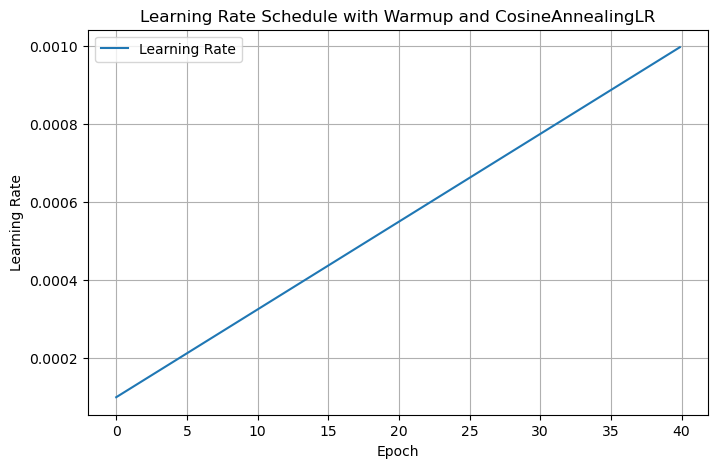

In [90]:
num_epochs = 40 # сколько всего эпох
lr = 1e-3
lr_min=1e-4

model = Detector("resnet50", num_classes=4, anchor_sizes=(30, 50, 140, 300), anchor_ratios=(0.5, 1, 1.6, 2), unfreeze_last=2).to(device)
# model = Detector("resnet50", num_classes=4, anchor_sizes=(30, 50, 140), anchor_ratios=(0.5, 1, 1.6), unfreeze_last=2).to(device)
model = model.to(device)

steps_per_epoch = len(train_dataloader)  # сколько батчей в одной эпохе
total_iters = num_epochs * steps_per_epoch  # сколько всего итераций
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# 1. Warmup scheduler
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=0.1,  # начальный lr = 10% от lr
    total_iters=total_iters    # сколько шагов греть
)

# 2. Основной scheduler
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - 1,   # сколько эпох будет косинус
    eta_min=lr_min            # минимальный learning rate 5e-5
)

# 3. Склеиваем их
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, main_scheduler],
    milestones=[total_iters]  # после 500 итераций переключиться на основной
)


# scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=500) 
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=5e-5)

iou_loss = DIoULoss()
focal_loss = SigmoidFocalLoss()
compute_loss = ComputeLoss(iou_loss, focal_loss, focal_loss, weight_bbox=10)

runner = Runner(model, compute_loss, optimizer, train_dataloader, device=device,
                score_threshold=0.1,
                assign_target_method = tal_assigner,
                assign_target_kwargs={"alpha":0.5, "beta":0.5},
                scheduler=scheduler,
                val_every=1,
                val_dataloader=test_dataloader)


# Собираем LR по итерациям
lrs = []
for step in range(total_iters):
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()  # обновляем learning rate

# Переводим итерации в эпохи
epochs = [step / steps_per_epoch for step in range(total_iters)]

# Рисуем график
plt.figure(figsize=(8, 5))
plt.plot(epochs, lrs, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule with Warmup and CosineAnnealingLR")
plt.grid(True)
plt.legend()
plt.show()

# Параметры alpha и beta для метода tal_assigner регулируют баланс между различными частями алгоритма Task Alignment Learning (TAL).
# Конкретное значение этих параметров зависит от ваших данных, модели и задачи. Давайте разберем:

# alpha: Это коэффициент для учета предсказанных классов. Он регулирует вес между предсказаниями модели и истинными метками в процессе вычисления лосса.
# Чем выше значение alpha, тем больше модель будет ориентироваться на улучшение точности классификации.
# Обычно для начала можно взять 0.5, что означает, что вклад от классификации и локализации будет равномерным.
# beta: Это коэффициент для учета позиции якоря (IoU). Он определяет важность геометрической точности в контексте выравнивания объектов с якорями.
# Если beta больше, то модель будет больше ориентироваться на точность локализации объектов.
# 0.5 — сбалансированное значение для начала.


# Когда использовать разные значения:
# alpha = 1.0, beta = 1.0: Это означает полное равенство значимости между классификацией и локализацией.

# alpha = 0.7, beta = 0.3: Можно использовать, если ваша задача более чувствительна к классификации,
# а локализация имеет второстепенное значение.

# alpha = 0.3, beta = 0.7: Подходит для задач, где локализация имеет большее значение, например,
# для детекции объектов с маленькими размерами или сильно перекрывающимися объектами.

# Рекомендации:
# Начать с alpha=0.5, beta=0.5 для сбалансированного подхода.
# Если видите, что ваша модель слишком часто ошибается в классификации, уменьшите alpha.
# Если ваша модель недостаточно хорошо локализует объекты, увеличьте beta.

In [83]:
assert next(model.parameters()).is_cuda

In [41]:
# ! nvidia-smi

In [91]:

runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/17 [00:00<?, ?it/s]

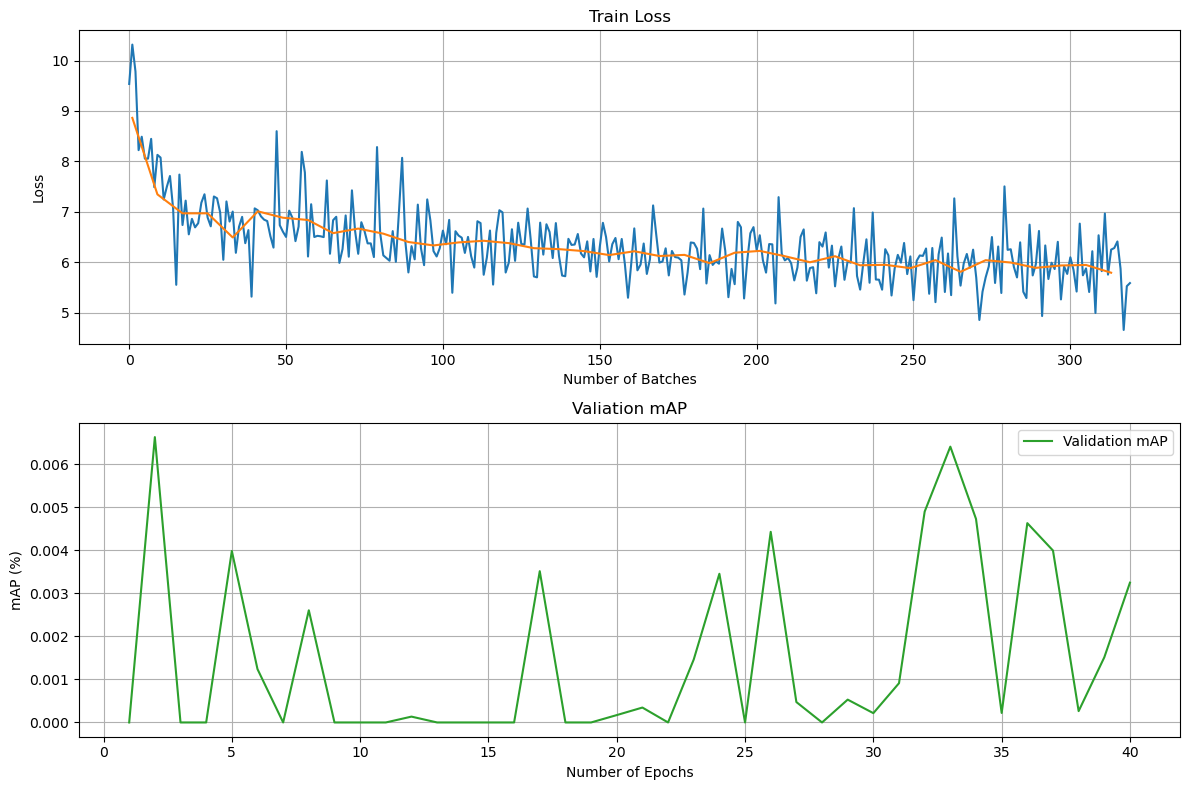

In [93]:
runner.plot_loss(row_figsize=4)

In [92]:
torch.save(model.state_dict(), "./model_detector_rn50_e40_b64")

In [ ]:
# Загрузить модель

# Создаешь НОВЫЙ экземпляр модели
model = Detector("resnet50", num_classes=4, anchor_sizes=(30, 50, 140), anchor_ratios=(0.5, 1, 1.6), unfreeze_last=2)
model.load_state_dict(torch.load("./detector_sd"))  # Загружаешь веса
model.to(device)  # Отправляешь на GPU или CPU
model.eval()  # Переводишь в режим инференса

In [46]:
@torch.no_grad()
def predict(model, images, device, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type='list'):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)
    final_predictions =  _filter_predictions(outputs, score_threshold=score_threshold, nms_threshold=nms_threshold,
                                             max_boxes_per_cls=max_boxes_per_cls, return_type=return_type)
    return final_predictions

In [47]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

def plot_examples(df, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)
    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image = Image.open(io.BytesIO(row['image']['bytes']))
        bboxes = row["objects"]['bbox']
        classes = row["objects"]['category']
        img = np.array(image)
        for bbox, label in zip(bboxes, classes):
            color = class_to_color[label]
            class_name = class_to_name[label]
            img = add_bbox(img, bbox, label=str(class_name), color=color)
        ax.imshow(img)
        ax.set_title(f"Image id: {row['image_id']}")
        ax.set_xticks([])
        ax.set_yticks([])

In [48]:
def plot_predictions(images, predictions, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))
            preds = predictions[ix + i]
            for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
                color = class_to_color[label+1]
                label = class_to_name[label+1]
                img = add_bbox(img, bbox, label=f"Class {label}: {score:.2f}", color=color)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

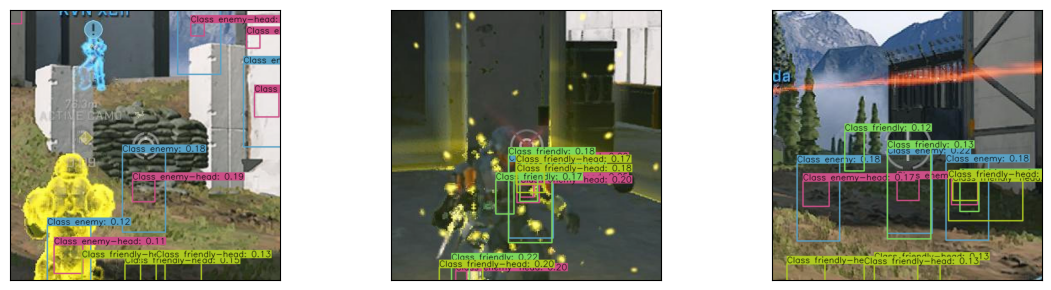

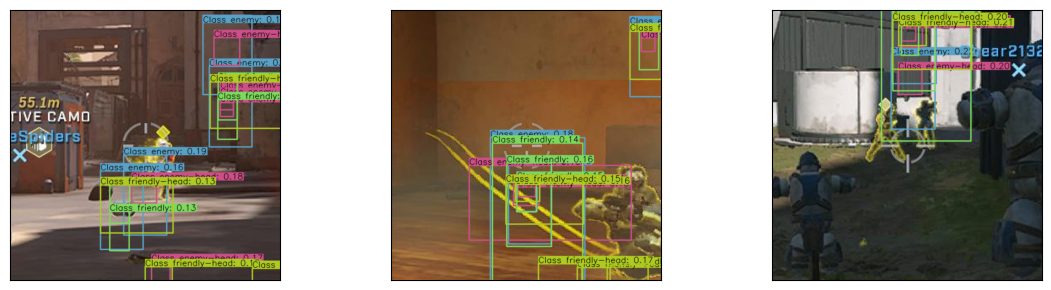

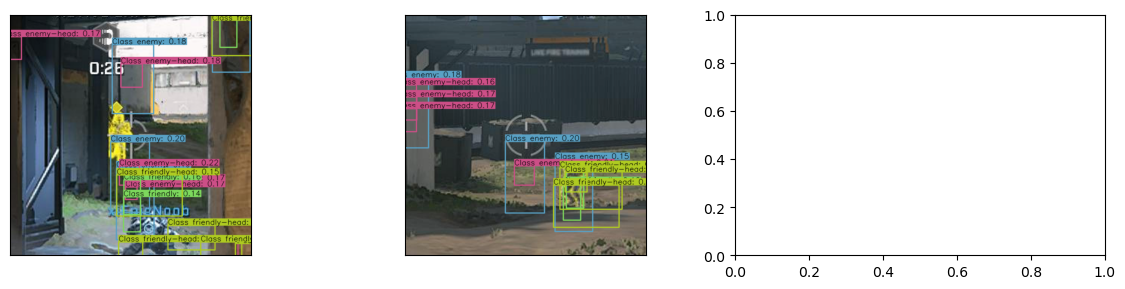

In [94]:
test_iter = iter(test_dataloader)

score_threshold = 0.1
nms_threshold = 0.4

images, _ = next(test_iter)
preds = predict(model, images, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)
plot_predictions(images, preds)

In [51]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def compute_coco_map(model, dataloader, device, score_threshold=0.01, nms_threshold=0.5, num_classes=4):
    """ Считаем mAP модели на данных из `dataloader`. """
    model.eval()
    ann_id = 1
    all_detections = []
    all_gt_annotations = []
    images_info = []

    for images, targets in tqdm(dataloader, desc="Dataset Evaluation"):
        # Делаем предсказание для всех картинок в батче
        predictions = predict(model, images, device, score_threshold, nms_threshold)
        # Сохраняем изначальные картинки, предсказания и таргет в формате COCO
        for i in range(images.shape[0]):
            image_id = targets[i]["image_id"]
            images_info.append({
                "id": image_id,
                "width": images[i].shape[1],
                "height": images[i].shape[2]
            })

            # Сохраняем предсказания модели в формате COCO
            img_pred = predictions[i]
            for box, cls, sc in zip(img_pred["boxes"], img_pred["labels"], img_pred["scores"]):
                detection = {
                    "image_id": image_id,
                    "category_id": cls + 1,  # Классы в COCO начинаются с 1
                    "bbox": list(box),  # Бокс в COCO формате [x, y, w, h]
                    "score": sc
                }
                all_detections.append(detection)

            # Сохраняем таргет в формате COCO
            gt_boxes = targets[i]['boxes'].cpu().numpy().tolist()
            gt_labels = targets[i]['labels'].cpu().numpy().tolist()
            for box, label in zip(gt_boxes, gt_labels):
                gt_annotation = {
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": label + 1,
                    "bbox": box,
                    "area": box[2] * box[3],
                    "iscrowd": 0
                }
                all_gt_annotations.append(gt_annotation)
                ann_id += 1

    coco_gt_dict = {
        "images": images_info,
        "annotations": all_gt_annotations,
        "categories": [{"id": i+1, "name": f"class_{i}"} for i in range(model.num_classes)]
    }

    coco_gt = COCO()
    coco_gt.dataset = coco_gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(all_detections)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    overall_mAP = coco_eval.stats[0]
    print(f"Validation mAP: {overall_mAP:.4f}\n\n")

    class_maps = {}
    for cat_id in range(1, num_classes + 1):
        class_name = class_to_name[cat_id]
        print(f"\nmAP for class {class_name}")
        print("-" * 50)
        coco_eval_cat = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval_cat.params.catIds = [cat_id]
        coco_eval_cat.params.imgIds = coco_gt.getImgIds(catIds=[cat_id])
        coco_eval_cat.evaluate()
        coco_eval_cat.accumulate()
        coco_eval_cat.summarize();
        ap = coco_eval_cat.stats[0]
        class_maps[cat_id] = ap

In [97]:
score_threshold = 0.1
nms_threshold = 0.5
compute_coco_map(model, test_dataloader, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)

Dataset Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.5

## Выводы:

В проекте использовались улучшения:
* Mixed Precision Training (FP16) - увеличение скорости обучения на 50-60%
* Более сильные аугментации - увеличение количества данных
* SigmoidFocalLoss - улучшение распознавания объектов
* Backbone resnet50 - для баланса скорость/точность
* Wwarm‑up - прогрессивная скорость обучения